<a href="https://www.kaggle.com/code/princelv84/dog-vs-cat-cnn-classifier?scriptVersionId=291798879" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🐶 Dog vs Cat 🐱 CNN Classifier

**Dataset:** [Dogs vs Cats - Kaggle](https://www.kaggle.com/datasets/princelv84/dogsvscats)  
**Author:** Lovnish Verma  
**Made with ❤️ for Machine Learning Beginners**

---

### Project Overview
This notebook demonstrates how to build a **Convolutional Neural Network (CNN)** to classify images of **dogs** and **cats**. It covers:

- Dataset preparation and augmentation  
- CNN model building  
- Training with callbacks  
- Evaluation using metrics and confusion matrix  
- Single image prediction  

---

### Goals
- Learn to preprocess images and use `ImageDataGenerator`  
- Understand CNN architecture for binary image classification  
- Visualize training performance and model predictions  


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!ls /kaggle/input/dogsvscats/

test  train


In [3]:
# Import Required Libraries
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

2026-01-14 08:50:39.823599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768380640.007153      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768380640.059776      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Setup and Configuration
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 2


In [5]:
!ls /kaggle/working

__notebook__.ipynb


In [6]:
# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Define paths and constants
INPUT_DIR = '/kaggle/input/dogsvscats/train'     # Source dataset directory
WORK_DIR = '/kaggle/working'                       # Working directory
SAMPLE_DIR = os.path.join(WORK_DIR, 'sample')      # Path to hold sampled subset
IMG_HEIGHT, IMG_WIDTH = 150, 150                   # Image size to resize to
BATCH_SIZE = 32                                    # Batch size for data generators
EPOCHS = 20                                        # Number of training epochs

In [7]:
# Prepare a Small Sample Dataset
def prepare_data(src, size=2000):
    """
    Prepare a subset of data with balanced classes for training and validation.
    - 1600 images for training (800 cats, 800 dogs)
    - 400 images for validation (200 cats, 200 dogs)
    """
    folders = ['train/cats', 'train/dogs', 'validation/cats', 'validation/dogs']
    for folder in folders:
        os.makedirs(os.path.join(SAMPLE_DIR, folder), exist_ok=True)

    # List and shuffle filenames
    cats = os.listdir(os.path.join(src, 'cats'))
    dogs = os.listdir(os.path.join(src, 'dogs'))
    random.shuffle(cats)
    random.shuffle(dogs)

    train_n, val_n = int(size * 0.4), int(size * 0.1)

    # Copy training images
    for i in range(train_n):
        shutil.copy(os.path.join(src, 'cats', cats[i]), os.path.join(SAMPLE_DIR, 'train/cats'))
        shutil.copy(os.path.join(src, 'dogs', dogs[i]), os.path.join(SAMPLE_DIR, 'train/dogs'))

    # Copy validation images
    for i in range(val_n):
        shutil.copy(os.path.join(src, 'cats', cats[train_n+i]), os.path.join(SAMPLE_DIR, 'validation/cats'))
        shutil.copy(os.path.join(src, 'dogs', dogs[train_n+i]), os.path.join(SAMPLE_DIR, 'validation/dogs'))

# Prepare the sample dataset
prepare_data(INPUT_DIR)

# Data Generators with Augmentation

# For training: use data augmentation to improve generalization
train_aug = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values
    rotation_range=20,          # Random rotation
    zoom_range=0.15,            # Random zoom
    width_shift_range=0.1,      # Horizontal shift
    height_shift_range=0.1,     # Vertical shift
    shear_range=0.15,           # Shear transformation
    horizontal_flip=True        # Random horizontal flip
)

# For validation: only normalize, no augmentation
val_aug = ImageDataGenerator(rescale=1./255)

# Load training data from directories
train_gen = train_aug.flow_from_directory(
    os.path.join(SAMPLE_DIR, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Load validation data from directories
val_gen = val_aug.flow_from_directory(
    os.path.join(SAMPLE_DIR, 'validation'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False   # Important for evaluation and predictions
)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [8]:
# Build the CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (cat vs dog)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # Stop early if no improvement
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-4) # Reduce learning rate on plateau
]

# Train the Model
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=val_gen.samples // BATCH_SIZE,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1768380663.570726      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768380663.571381      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can i

Epoch 1/20


I0000 00:00:1768380668.183001      76 service.cc:148] XLA service 0x7b913000e590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768380668.184082      76 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1768380668.184107      76 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1768380668.567383      76 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/50 ━━━━━━━━━━━━━━━━━━━━ 6:18 8s/step - accuracy: 0.4375 - loss: 0.6893

I0000 00:00:1768380672.868799      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 205ms/step - accuracy: 0.5087 - loss: 0.7027 - val_accuracy: 0.4792 - val_loss: 0.7192 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.5011 - loss: 0.7000 - val_accuracy: 0.4844 - val_loss: 0.6947 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - accuracy: 0.5252 - loss: 0.6913 - val_accuracy: 0.5208 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - accuracy: 0.5278 - loss: 0.6914 - val_accuracy: 0.5182 - val_loss: 0.6896 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.5497 - loss: 0.6809 - val_accuracy: 0.5000 - val_loss: 0.6908 - learning_rate: 0.0010
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - accuracy: 0.5514 - loss: 0.6883 - val_accuracy: 0.5443 - val_loss: 0.6887 - learning_rate: 0.0010
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.5765 - loss: 0.6778 - val_accura

In [9]:
# Plot Accuracy and Loss Curves
def plot_history(hist):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Train')
    plt.plot(hist.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train')
    plt.plot(hist.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

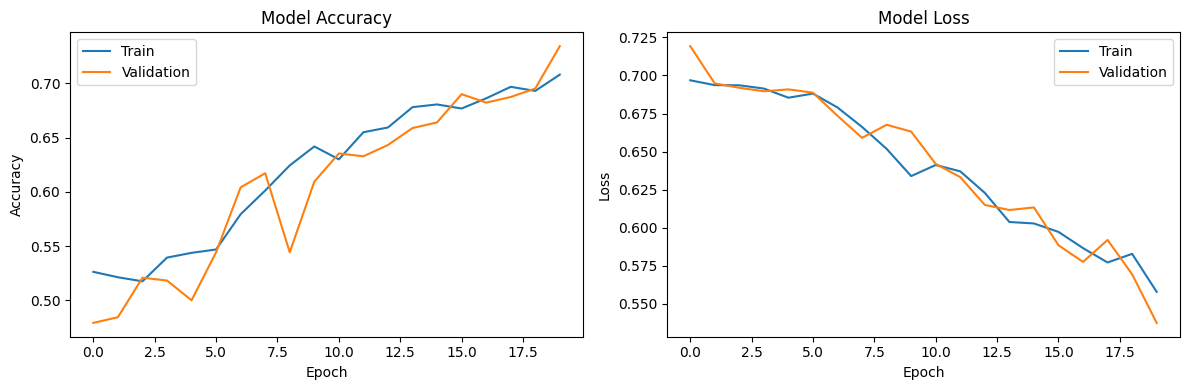

In [10]:
# Call the plotting function
plot_history(history)

In [11]:
# Final Evaluation on Validation Data
val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

Validation Accuracy: 0.7425, Loss: 0.5268


In [12]:
# Classification Report
val_gen.reset()  # Ensure ordering is preserved
preds = (model.predict(val_gen) > 0.5).astype(int).flatten()
y_true = val_gen.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


In [13]:
# Print precision, recall, f1-score
print(classification_report(y_true, preds, target_names=['Cat', 'Dog']))

              precision    recall  f1-score   support

         Cat       0.78      0.68      0.72       200
         Dog       0.71      0.81      0.76       200

    accuracy                           0.74       400
   macro avg       0.75      0.74      0.74       400
weighted avg       0.75      0.74      0.74       400



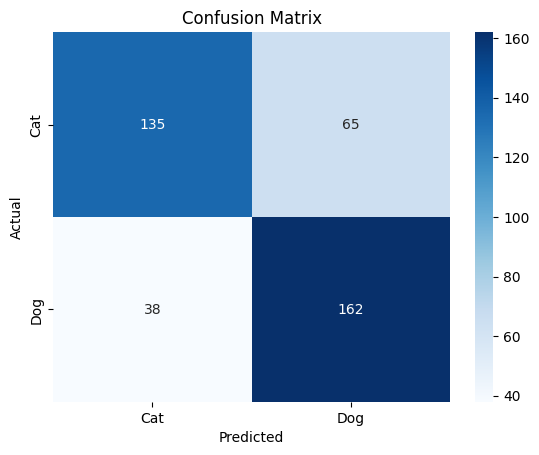

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_true, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [15]:
# Save the Model (Legacy way- not recommended)
# model.save(os.path.join(WORK_DIR, 'dogs_vs_cats_model.h5'))

# Save Model in new Keras format (recommended)
final_model_path = os.path.join(WORK_DIR, 'dogs_vs_cats_model.keras')
model.save(final_model_path)
print("Final model saved at:", final_model_path)

Final model saved at: /kaggle/working/dogs_vs_cats_model.keras


In [16]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the saved model (Legacy way- not recommended)
# model = load_model('/kaggle/working/dogs_vs_cats_model.h5')

# Load Model
loaded_model = tf.keras.models.load_model(final_model_path)
print("Loaded model, re-evaluating...")
loss, acc = loaded_model.evaluate(val_gen, verbose=0)
print(f"Reloaded model Accuracy: {acc:.4f}")

model = loaded_model

# Constants
IMG_HEIGHT = 150
IMG_WIDTH = 150

Loaded model, re-evaluating...
Reloaded model Accuracy: 0.7425


In [17]:
# Function to predict a single image
def predict_image(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize

    # Prediction
    prediction = model.predict(img_array, verbose=0)
    confidence = prediction[0][0]

    # Display the image with prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {'Dog' if confidence > 0.5 else 'Cat'}\nConfidence: {confidence:.2f}" if confidence > 0.5 else f"Prediction: Cat\nConfidence: {1 - confidence:.2f}")
    plt.show()

    return "Dog" if confidence > 0.5 else "Cat"

In [18]:
!ls /kaggle/input/dogsvscats/test

cats  dogs


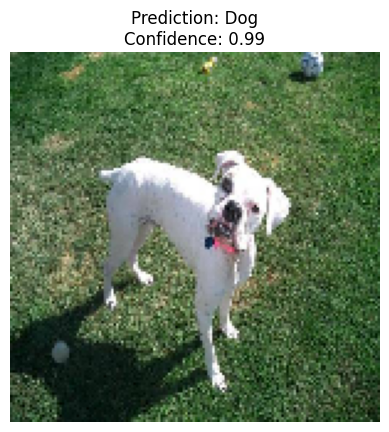

Predicted class: Dog


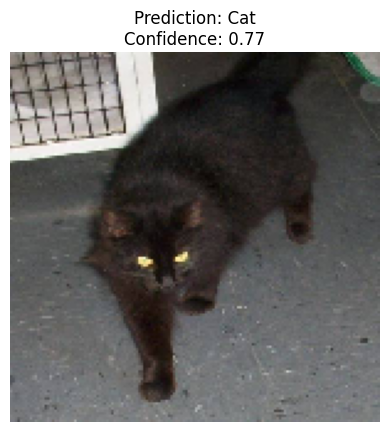

Predicted class: Cat


In [19]:
result = predict_image("/kaggle/input/dogsvscats/test/dogs/dog.10028.jpg")
print("Predicted class:", result)


result = predict_image("/kaggle/input/dogsvscats/test/cats/cat.2837.jpg")
print("Predicted class:", result)